In [6]:
import sys
sys.path.append('..')

import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import pandas as pd
import seaborn as sns

labels = {
    'Background': 0,
    'Tubules': 1,
    # 'Vein': 2,
    'Vein / Indeterminate vessel ': 2,  # Same as Vein - relabelled
    'Artery': 3,
    'Glomeruli': 4
}

alpha = 1.0
# colors = [purple, red, green, yellow, blue]
# colors = [(128/255, 0, 128/255, alpha), # purple (background)
#             (1, 0, 0, alpha), # red (tubules)
#             (1, 1, 0, alpha), # yellow (indeterminate)
#             (0, 1, 0, alpha), # green (artery)
#             (0, 0, 1, alpha)] # blue (glomeruli)
# cmap = mcolors.ListedColormap(colors)

colors = [(128/255, 0, 128/255, alpha), # purple (background)
            (1, 0, 0, alpha), # red (tubules)
            (1, 1, 0, alpha), # yellow (indeterminate)
            (50/255, 200/255, 50/255, alpha), # green (artery)
            (0, 0, 200/255, alpha)] # blue (glomeruli)
cmap = mcolors.ListedColormap(colors)

# new_colors = [(128/255, 0, 128/255),  # purple (background)
#               (225/255, 25/255, 25/255),  # red (tubules)
#               (255/255, 255/255, 50/255),  # yellow (indeterminate)
#               (75/255, 175/255, 75/255),  # green (artery)
#               (55/255, 125/255, 185/255)]  # blue (glomeruli)
# cmap = mcolors.ListedColormap(new_colors)

In [2]:
def plot_three(img, mask, edge_map):    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Image')

    ax[1].imshow(mask, cmap=cmap, vmin=0, vmax=4)
    ax[1].axis('off')
    ax[1].set_title('Mask')

    ax[2].imshow(edge_map, cmap='binary')
    ax[2].axis('off')
    ax[2].set_title('Edge Map')

    plt.tight_layout()
    plt.show()

# POST PROCESS

Using device: cuda


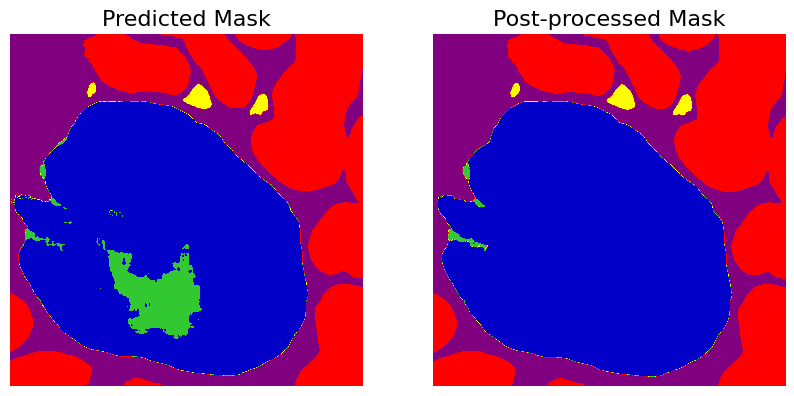

In [58]:
from unet.stochastic_unet import StochasticUNet
from utils.get_dataloaders import get_test_loader
from inference import postprocess, undo_normalisation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
test_path = '/vol/bitbucket/dks20/renal_ssn/labelbox_download/test_data_random.h5'
test_loader = get_test_loader(test_path)

num_preds = 1

model_path = '/vol/bitbucket/dks20/renal_ssn/checkpoints/stoch_unet_adamwcyclic_randomdataset_actualaug_nonorm_dropout20_retry/epoch98_dice_62446.pth'
model = StochasticUNet(in_channels=3, num_classes=5, rank=10).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# visualise_stochastic_preds(model, device, test_path, model_path, num_samples=5, num_preds=20)

counter = 0
with torch.no_grad():
    for idx, (img, mask, _) in enumerate(test_loader):
        if idx < 9:
            continue

        img = undo_normalisation(img.squeeze(0)).unsqueeze(0)

        img = img.to(device) # shape = (1, C, H, W)

        logits, output_dict = model(img) # logits shape = (1, num_classes, H, W)
        dist = output_dict['distribution']

        logits = logits.argmax(dim=1).squeeze(0).cpu().numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        ax[0].imshow(logits, cmap=cmap, vmin=0, vmax=4)
        ax[0].axis('off')
        ax[0].set_title('Predicted Mask', fontsize=16)

        logits_post = postprocess(logits)

        ax[1].imshow(logits_post, cmap=cmap, vmin=0, vmax=4)
        ax[1].axis('off')
        ax[1].set_title('Post-processed Mask', fontsize=16)

        # plt.tight_layout()

        plt.savefig('post_process.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)

        plt.show()

        # img = undo_normalisation(img.squeeze(0).cpu())
        # plt.imshow(img.permute(1, 2, 0).numpy())
        # plt.axis('off')
        # plt.title('Image')
        # plt.show()

        counter += 1

        if counter >= num_preds:
            break


# MAJORITY VOTE

In [76]:
from unet.stochastic_unet import StochasticUNet
from utils.get_dataloaders import get_test_loader
from inference import undo_normalisation, majority_voting

SEED = 46
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
test_path = '/vol/bitbucket/dks20/renal_ssn/labelbox_download/test_data_random.h5'
test_loader = get_test_loader(test_path)

num_preds = 1

# idx = 9 (bad vote)
# idx = 24 (good vote)

model_path = '/vol/bitbucket/dks20/renal_ssn/checkpoints/stoch_unet_adamwcyclic_randomdataset_actualaug_withnorm_dropout20/epoch84_dice_62359.pth'
model = StochasticUNet(in_channels=3, num_classes=5, rank=10).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# visualise_stochastic_preds(model, device, test_path, model_path, num_samples=5, num_preds=20)

counter = 0
with torch.no_grad():
    for idx, (img, mask, _) in enumerate(test_loader):
        if idx < 24:
            continue

        # img = undo_normalisation(img.squeeze(0)).unsqueeze(0)

        img = img.to(device) # shape = (1, C, H, W)

        logits, output_dict = model(img) # logits shape = (1, num_classes, H, W)
        dist = output_dict['distribution']

        logits = logits.argmax(dim=1).squeeze(0).cpu().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(mask.squeeze(0).cpu().numpy(), cmap=cmap, vmin=0, vmax=4)
        ax[0].axis('off')
        ax[0].set_title('True Mask', fontsize=16)

        ax[1].imshow(logits, cmap=cmap, vmin=0, vmax=4)
        ax[1].axis('off')
        ax[1].set_title('Predicted Mask', fontsize=16)

        # MAJORITY VOTING
        samples_uncertainty = dist.rsample((20,)).cpu() # shape = (20, 1, num_classes, H, W) (samples for majority voting + uncertainty calc)
        samples_uncertainty = samples_uncertainty.squeeze(1) # shape = (20, num_classes, H, W)

        majority_vote = majority_voting(samples_uncertainty) # shape = (H, W)
        # majority_vote = postprocess(majority_vote.numpy()) # shape = (H, W)

        ax[2].imshow(majority_vote.numpy(), cmap=cmap, vmin=0, vmax=4)
        ax[2].axis('off')
        ax[2].set_title('Majority Vote', fontsize=16)

        # plt.tight_layout()
        plt.savefig('inference/goodvote.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.show()

        # img = undo_normalisation(img.squeeze(0).cpu())
        # plt.imshow(img.permute(1, 2, 0).numpy())
        # plt.axis('off')
        # plt.title('Image')
        # plt.show()

        counter += 1

        if counter >= num_preds:
            break


Using device: cuda


# ENTROPY

Using device: cuda


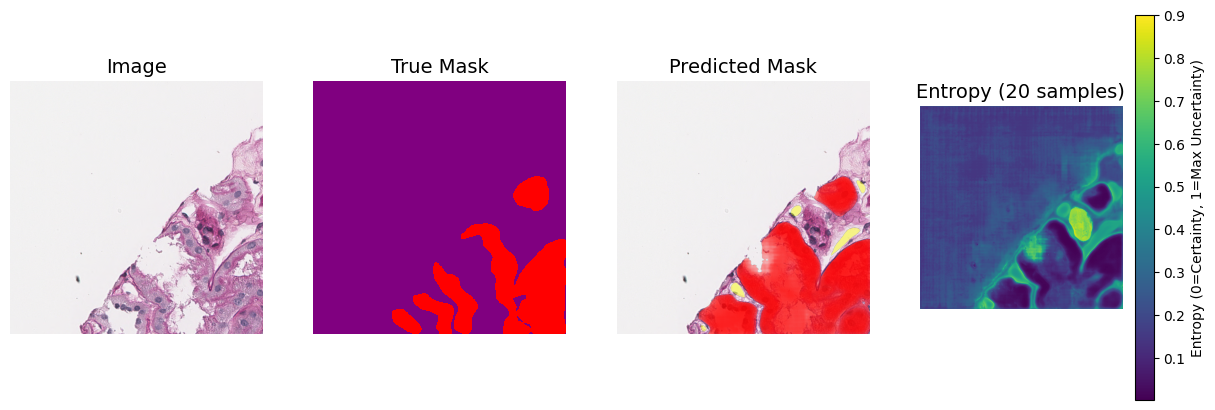

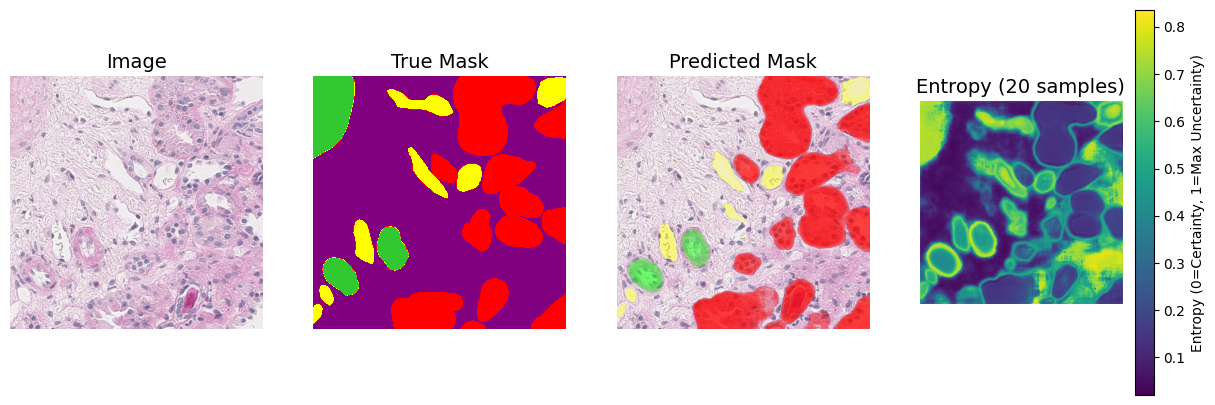

In [18]:
from unet.stochastic_unet import StochasticUNet
from utils.get_dataloaders import get_test_loader
from inference import undo_normalisation, calculate_entropy, postprocess

SEED = 44
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
test_path = '/vol/bitbucket/dks20/renal_ssn/labelbox_download/test_data_random.h5'
test_loader = get_test_loader(test_path)

num_preds = 20

# idx = 10 (bad vote)

model_path = '/vol/bitbucket/dks20/renal_ssn/checkpoints/stoch_unet_adamwcyclic_randomdataset_actualaug_withnorm_dropout20/epoch84_dice_62359.pth'
model = StochasticUNet(in_channels=3, num_classes=5, rank=10).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# visualise_stochastic_preds(model, device, test_path, model_path, num_samples=5, num_preds=20)

counter = 0
with torch.no_grad():
    for idx, (img, mask, _) in enumerate(test_loader):
        if idx != 8 and idx != 19:
            continue

        # img = undo_normalisation(img.squeeze(0)).unsqueeze(0)

        img = img.to(device) # shape = (1, C, H, W)

        logits, output_dict = model(img) # logits shape = (1, num_classes, H, W)
        dist = output_dict['distribution']

        logits = logits.argmax(dim=1).squeeze(0).cpu().numpy()
        logits = postprocess(logits)
        mask = mask.squeeze(0).cpu().numpy()

        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        
        img = undo_normalisation(img.squeeze(0).cpu()) # shape = (1, C, H, W)
        img = img.permute(1, 2, 0).numpy()
        ax[0].imshow(img)
        ax[0].axis('off')
        ax[0].set_title('Image', fontsize=14)

        ax[1].imshow(mask, cmap=cmap, vmin=0, vmax=4)
        ax[1].axis('off')
        ax[1].set_title('True Mask', fontsize=14)

        # ax[1].imshow(logits, cmap=cmap, vmin=0, vmax=4)
        # ax[1].axis('off')
        # ax[1].set_title('Predicted Mask', fontsize=16)

        # ENTROPY
        samples_uncertainty = dist.rsample((20,)).cpu() # shape = (20, 1, num_classes, H, W) (samples for majority voting + uncertainty calc)
        samples_uncertainty = samples_uncertainty.squeeze(1) # shape = (20, num_classes, H, W)

        entropy = calculate_entropy(samples_uncertainty)

        heatmap = ax[3].imshow(entropy, cmap='viridis')
        # cbar = fig.colorbar(heatmap, ax=ax[0, 5])
        cbar = fig.colorbar(heatmap)
        cbar.set_label('Entropy (0=Certainty, 1=Max Uncertainty)')
        ax[3].set_title('Entropy (20 samples)', fontsize=14)
        ax[3].axis('off')

        # OVERLAY
        alpha = 0.9 # Max transparency
        colors = [(128/255, 0, 128/255, 0), # purple (but transparent since alpha = 0)
            (1, 0, 0, alpha), # red
            (1, 1, 0, alpha), # yellow
            (0, 1, 0, alpha), # green
            (0, 0, 1, alpha)] # blue

        adjusted_colors = np.zeros((*entropy.shape, 4))  # Create an RGBA image
        for i in range(1, len(colors)):
            adjusted_colors[logits == i, :3] = colors[i][:3]  # Color
            adjusted_colors[logits == i, 3] = (1 - entropy[logits == i]) * colors[i][3]  # Alpha, modulated by uncertainty

        # img = undo_normalisation(img.squeeze(0).cpu()) # shape = (1, C, H, W)
        # img = img.permute(1, 2, 0).numpy() # shape = (H, W, C)
        ax[2].imshow(img)
        ax[2].set_title('Predicted Mask', fontsize=14)
        ax[2].imshow(adjusted_colors)
        ax[2].axis('off')
        
        # plt.tight_layout()
        plt.savefig('overlay19.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.show()

        # img = undo_normalisation(img.squeeze(0).cpu())
        # plt.imshow(img.permute(1, 2, 0).numpy())
        # plt.axis('off')
        # plt.title('Image')
        # plt.show()

        counter += 1

        if counter >= num_preds:
            break
